In [24]:
from sdo.models.autocalibration_models import Autocalibration6, Autocalibration16
import torch
import torch.nn as nn
import pandas as pd
from sdo.datasets.sdo_dataset import SDO_Dataset
from sdo.datasets.dimmed_sdo_dataset import DimmedSDO_Dataset
from sdo.pytorch_utilities import create_dataloader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import matplotlib.dates as mdates

import astropy.time
from astropy.visualization import time_support
import astropy.units as u
from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table

import datetime
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
#logger.setLevel(logging.DEBUG)
#logging.debug("test")

In [2]:
channels = ['0094','0131','0171','0193','0211','0304','0335']
DATA_BASEDIR = '/Users/cheung/AIA/SDOML_uncorrected/'

In [26]:
apodize = True
prefix = 'mark_experiment_euv_nothreshold_2011_2018_gunesh'
prefix = 'mark_experiment_euv_nothreshold_2010_2016_3hr_gunesh'
#prefix = 'mark_experiment_euv_nothreshold_2010_2016_gunesh_b16'

kernel_size = 3
if apodize: prefix = prefix+'_apodize'
if kernel_size != 3: prefix = prefix+'_k{0:1d}'.format(kernel_size)
print(prefix)
epoch  = 400

prefix = 'mark_experiment_euv_nothreshold_2010_2016_gunesh_apodize_m16'
#EXPERIMENT_RESULTS_AUTOCAL_mark_experiment_euv_nothreshold_2010_2016_gunesh_apodize_m16_0400_mark_experiment_euv_nothreshold_2010_2016_gunesh_apodize_m16_model.pth

modelfile = '/Users/cheung/AIA/SDOML_uncorrected/EXPERIMENT_RESULTS_AUTOCAL_{0:s}_{1:04d}_{0:s}_model.pth'.format(prefix,epoch)
print(modelfile)
model = Autocalibration16(input_shape=[7, 256, 256], output_dim=7, kernel_size=kernel_size)
model.load_state_dict(torch.load(modelfile,map_location=torch.device('cpu')))
model.eval()
print(model)

train_dataset = SDO_Dataset(data_basedir=DATA_BASEDIR,
                                            data_inventory='{}inventory.pkl'.format(DATA_BASEDIR),
                                            instr=['AIA','AIA','AIA','AIA','AIA','AIA','AIA'],
                                            channels=channels, yr_range=[2010,2019],
                                            mnt_step = 1,
                                            day_step = 5,
                                            h_step   = 1,
                                            min_step = 1,
                                            resolution=512,
                                            subsample =2,
                                            normalization=0, 
                                            scaling = True,
                                            shuffle = False,
                                            holdout = False,
                                            test_ratio = 0,
                                            test=False, apodize=apodize)

train_loader = create_dataloader(train_dataset, batch_size=4, num_dataloader_workers=1, train=False)

mark_experiment_euv_nothreshold_2010_2016_3hr_gunesh_apodize
/Users/cheung/AIA/SDOML_uncorrected/EXPERIMENT_RESULTS_AUTOCAL_mark_experiment_euv_nothreshold_2010_2016_gunesh_apodize_m16_0400_mark_experiment_euv_nothreshold_2010_2016_gunesh_apodize_m16_model.pth
Autocalibration16(
  (_conv2d1): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d1_maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_conv2d2): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d2_maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_fc): Linear(in_features=11664, out_features=7, bias=True)
)
['/Users/cheung/AIA/SDOML_uncorrected/2010/AIA20100516_0006_0094.mm', '/Users/cheung/AIA/SDOML_uncorrected/2010/AIA20100516_0006_0131.mm', '/Users/cheung/AIA/SDOML_uncorrected/2010/AIA20100516_0006_0171.mm', '/Users/cheung/AIA/SDOML_uncorrected/2010/AIA20100516_0006_0193.mm', '/Users/cheung/AIA/SDOML_uncorrected/2010/AIA20100516_0006

In [27]:
time_0 = astropy.time.Time('2010-06-01T00:00:00', scale='utc')
now = astropy.time.Time.now()
time = time_0 + np.arange(0, (now - time_0).to(u.day).value, 7) * u.day
correction_table = get_correction_table()
deg = {}
for c in channels:
    deg[c] = [degradation(int(c)*u.angstrom, t, correction_table=correction_table) for t in time]

In [28]:
def run(model, prefix):
    final_predictions = []
    i=0
    with torch.no_grad():
        #for batch_idx, (input_data, files) in enumerate(train_loader):
        for batch_idx, (input_data,files) in enumerate(train_loader):
            if batch_idx==0:
                output = model(input_data)
                total_output = output
                dates = np.array(files)
            else:
                output = model(input_data)
                total_output = torch.cat((total_output, output), 0)
                dates = np.append(dates,files,axis=1) 
    total_output_np = total_output.numpy()
    x_values0 = [datetime.datetime.strptime(i.split('/')[-1][3:11],"%Y%m%d").date() for i in dates[0,:]] #x_values for 009
    x_values0 = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in x_values0])
    
    time_support()
    colors = ['red','green','magenta', 'blue', 'yellow', 'gold', 'black']
    for c in range(len(channels)):
        fig = plt.figure(figsize=(15,7))
        ax = plt.gca()
        plt.plot(x_values0, total_output_np[:,c], 'o', label=channels[c], color=colors[c], alpha=0.5)
        #plt.plot(total_output_np[:,c],'*', label=channels[c])
        plt.plot(time, deg[channels[c]], color=colors[c], linewidth=4, alpha=0.9)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.legend(loc='upper right',fontsize=16)
        plt.title('DNN-retrieved EUV degradation factors', fontsize=15)
        plt.text(time[0],0.01,modelfile.split('/')[-1][27:])
        plt.fill_betweenx([1.0,1.0],astropy.time.Time('2010-06-01T00:00:00', scale='utc'),astropy.time.Time('2018-12-31T00:00:00', scale='utc'))
        #plt.fill([astropy.time.Time('2010-06-01T00:00:00', scale='utc'),astropy.time.Time('2018-12-31T00:00:00', scale='utc')], [1.0, 1.0])
        ax.set_ylim(0,1.1)
        
        plt.savefig('/Users/cheung/AIA/SDOML_uncorrected/{0:s}_{1:04d}.png'.format(prefix,c))

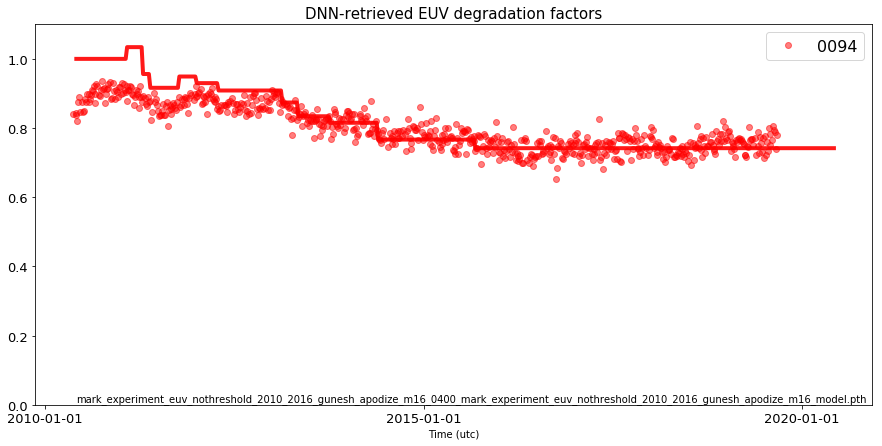

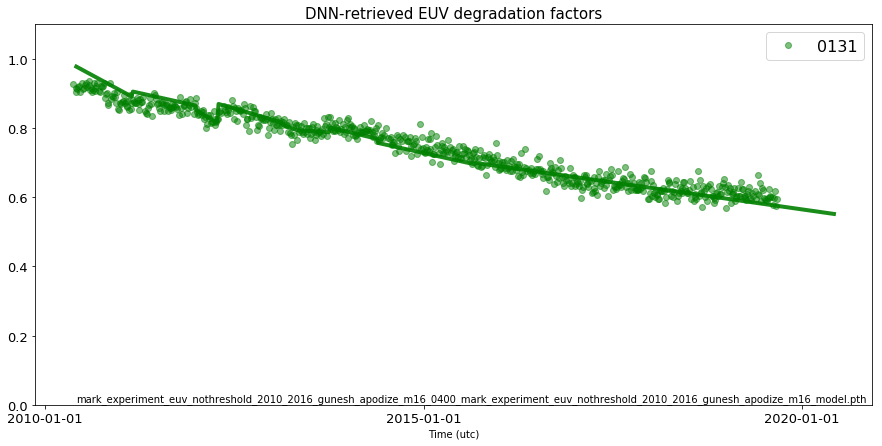

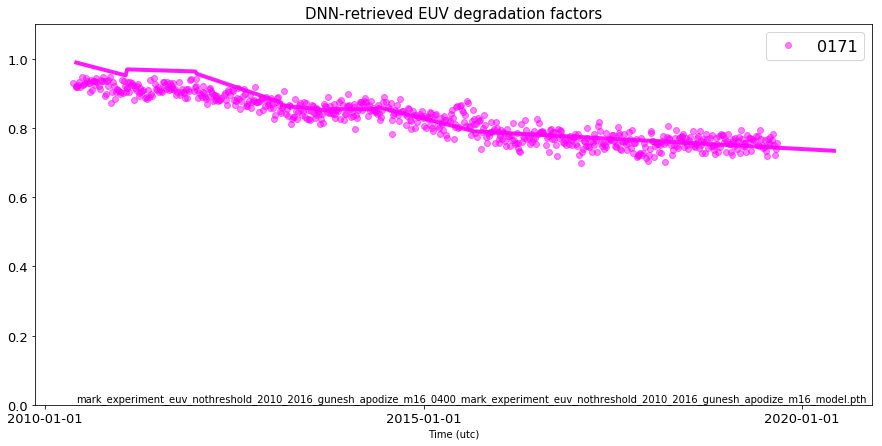

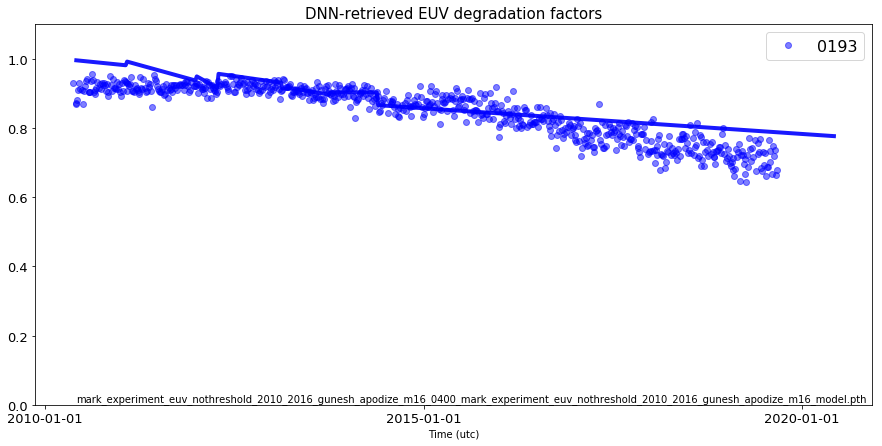

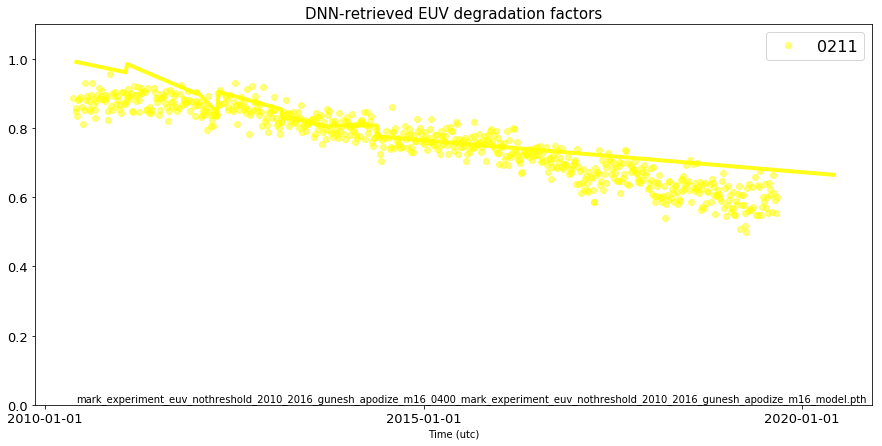

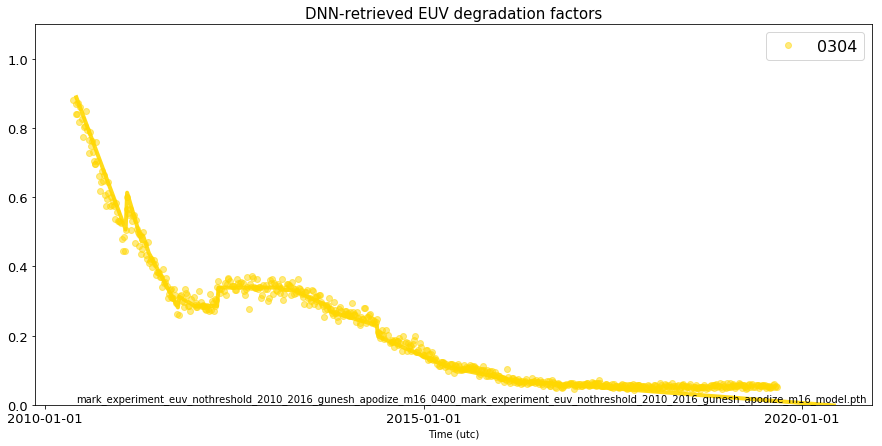

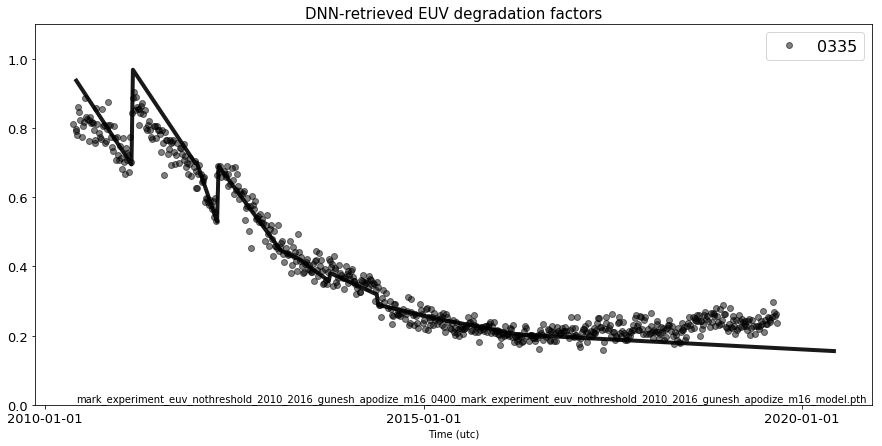

In [29]:
run(model, prefix)

In [30]:
with torch.no_grad():
    for batch_idx, (input_data,files) in enumerate(train_loader):
        #output = model(input_data)
        #total_output = output
        dates = np.array(files)
        print(batch_idx)
        break

0


In [31]:
print(kernel_size)
latent = nn.functional.conv2d(input_data, model.state_dict()['_conv2d1.weight'])
print(latent.std())
ones = torch.ones(latent[0,:,:,:].shape)
for c in range(ones.shape[0]):
    ones[c,:,:]*=model.state_dict()['_conv2d1.bias'][c]
for l in latent[:]:
    l += ones
print(latent.std())    
latent = nn.functional.max_pool2d(latent, kernel_size=kernel_size, stride=kernel_size)
latent[latent < 0.0] = 0.0
print(latent.std())
print(latent.shape)
latent2 = nn.functional.conv2d(latent, model.state_dict()['_conv2d2.weight'])
ones = torch.ones(latent2[0,:,:,:].shape)
for c in range(ones.shape[0]):
    ones[c,:,:]*=model.state_dict()['_conv2d2.bias'][c]
for l in latent2[:]:
    l += ones    
latent2 = nn.functional.max_pool2d(latent2, kernel_size=kernel_size, stride=kernel_size)
latent2[latent2 < 0.0] = 0.0
print(latent2.shape)

3
tensor(0.4343)
tensor(0.4336)
tensor(0.0520)
torch.Size([4, 64, 84, 84])
torch.Size([4, 16, 27, 27])


In [32]:
def bytescale(img,vmin=0,vmax=255):
    return np.clip((img-vmin)/(vmax-vmin),0,1)

print(model.state_dict().keys())
w =  model.state_dict()['_conv2d1.weight'].numpy()
print(w.shape)

def visualize_images(img, dest=plt, figsize=None,vmin=0,vmax=1):
    nc = img.shape[0]
    if figsize ==None:
        figsize=(3*nc,3)
    fig = dest.figure(figsize=figsize)
    gs  = fig.add_gridspec(1,nc)
    for c in range(nc):
        this_panel = fig.add_subplot(gs[c])
        this_panel.imshow(img[c],vmin=vmin,vmax=vmax, cmap='gray')
        this_panel.set_title('{}'.format(channels[c]),fontsize=7)

def visualize_latent(latent,dest=plt,figsize=(10,10),vmin=0,vmax=1,cols=8,cmap='jet',label_color='white', showSum=False, fontsize=14):
    nc = latent.shape[0]
    fig = dest.figure(figsize=figsize)
    gs  = fig.add_gridspec(max([int(nc/cols),1]),cols)
    total=''
    for c in range(nc):
        this_panel = fig.add_subplot(gs[int(c/cols), c % cols])
        this_panel.imshow(latent[c].numpy(),vmin=vmin,vmax=vmax,cmap=cmap)
        this_panel.get_xaxis().set_visible(False)
        this_panel.get_yaxis().set_visible(False)
        this_panel.margins(0.0,0.0)
        if showSum:
            total = ': {0:.3f}'.format(latent[c].numpy().sum())
        this_panel.annotate('{}'.format(c)+total, (1.2,20.5),color=label_color, fontsize=fontsize)

def visualize_multi_kernels(w, channels=[2,3,5], dest=None, figsize=(10,10)):
    if dest == None:
        dest = plt
        fig = dest.figure(figsize=figsize)
        gs  = fig.add_gridspec(int(w.shape[0]/8),8)
    else:
        gs = dest.subplots(int(w.shape[0]/8),8)
        fig = dest
        
    for i in range(w.shape[0]):
        this_panel = fig.add_subplot(gs[int(i/8), i  % 8])
        #b = ax[int(i/8), i  % 8]
        this_panel.imshow(bytescale(np.transpose(w[i, channels, :,:],(1,2,0)), vmin=-0.25, vmax=0.25))
        this_panel.annotate('{}'.format(i),(0.2,1.5),color='white',fontsize=14)
        this_panel.get_xaxis().set_visible(False)
        this_panel.get_yaxis().set_visible(False)
        this_panel.margins(0.0,0.0)
        

odict_keys(['_conv2d1.weight', '_conv2d1.bias', '_conv2d2.weight', '_conv2d2.bias', '_fc.weight', '_fc.bias'])
(64, 7, 3, 3)


(64, 7, 3, 3) torch.Size([4, 64, 84, 84])


<Figure size 1224x1080 with 0 Axes>

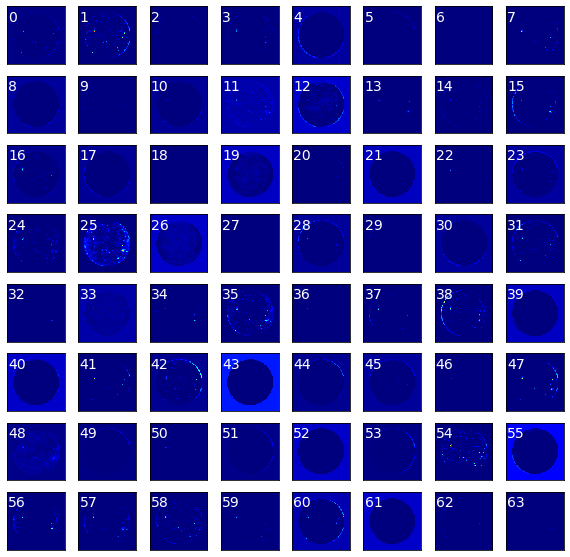

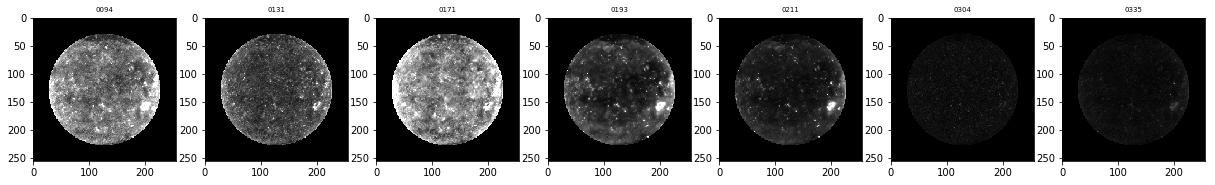

In [33]:
row=3
#fig, ax = plt.subplots(1,2)
fig = plt.figure(figsize=(17,15))
gs  = fig.add_gridspec(1,2)
print(w.shape, latent.shape)

#visualize_multi_kernels(w, channels = [0,3,4]) #, dest=fig.add_subplot(gs[0,0]))
#plt.show()
visualize_latent(latent[row])
plt.show()
visualize_images(input_data[row],vmin=0,vmax=0.4)
plt.savefig('sample_images.jpg')

In [34]:
#visualize_multi_kernels(model.state_dict()['_conv2d2.weight'], channels = [0,3,4], figsize=(20,20)) #, dest=fig.add_subplot(gs[0,0]))
#plt.show()
#visualize_latent(latent2[row],figsize=(30,30))
#plt.show()

In [35]:
fc = model.state_dict()['_fc.weight']
print(fc.shape)
fc = fc.reshape(7,latent2.shape[1],latent2.shape[2],latent2.shape[3])
print(fc.shape)

torch.Size([7, 11664])
torch.Size([7, 16, 27, 27])


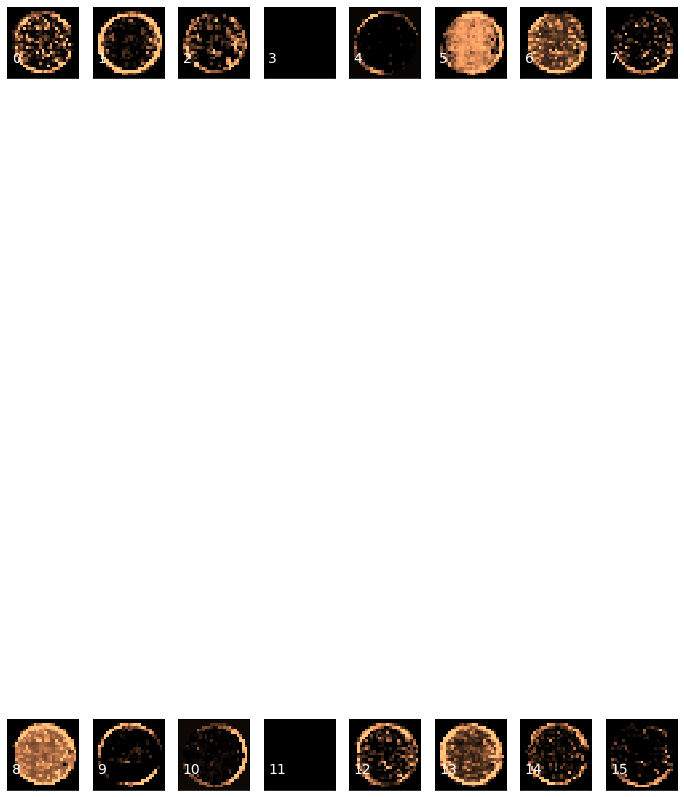

In [36]:
visualize_latent(latent2[row],figsize=(12,24),vmin=0,vmax=0.1,cmap='copper')
plt.savefig('latent2.jpg')

In [56]:
#visualize_latent(fc[:,67],figsize=(10,20))
activation = []
for i in range(fc.shape[1]):
    activation.append(torch.abs(fc[:,i,:,:]).mean().numpy())

In [57]:
fc.shape

torch.Size([7, 128, 27, 27])

In [58]:
arg_activation = np.argsort(np.array(activation))
arg_activation[-1]

116

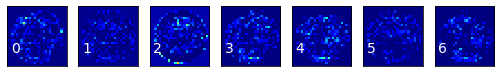

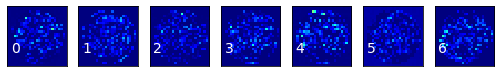

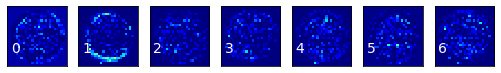

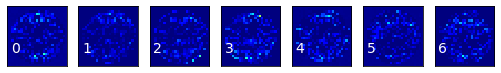

In [59]:
visualize_latent(fc[:,arg_activation[-1]],figsize=(10,20))
visualize_latent(fc[:,arg_activation[-2]],figsize=(10,20))
visualize_latent(fc[:,arg_activation[-3]],figsize=(10,20))
visualize_latent(fc[:,25],figsize=(10,20))


In [60]:
latent2[row].shape, fc[0].shape


(torch.Size([128, 27, 27]), torch.Size([128, 27, 27]))

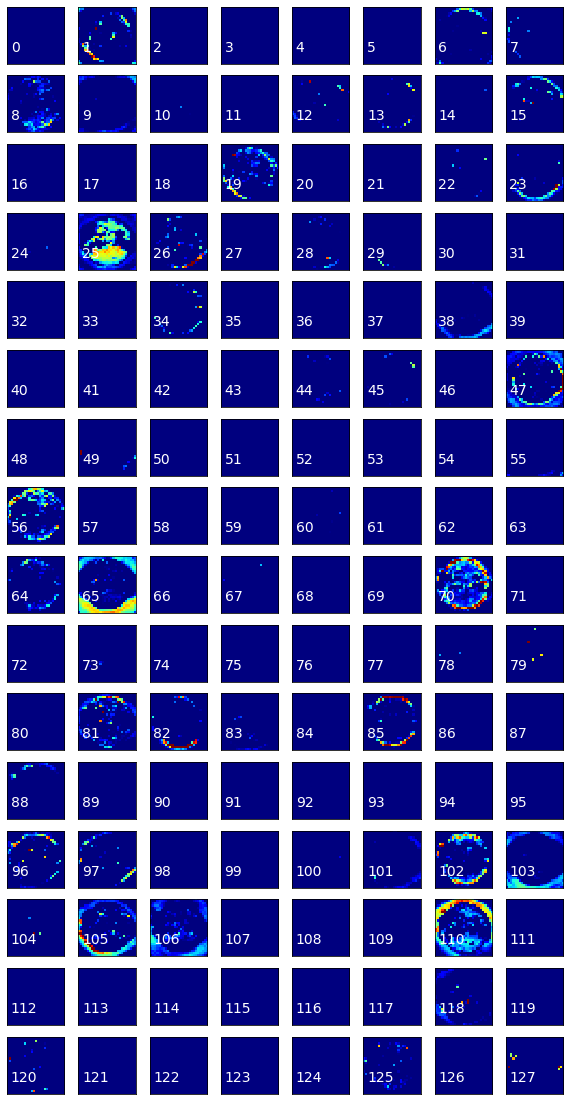

In [61]:
visualize_latent(latent2[row],figsize=(10,20),cols=8, vmin=0.0,vmax=0.1)

torch.Size([128, 27, 27])
torch.Size([128, 27, 27])
torch.Size([128, 27, 27])
torch.Size([128, 27, 27])
torch.Size([128, 27, 27])
torch.Size([128, 27, 27])
torch.Size([128, 27, 27])


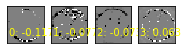

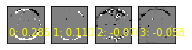

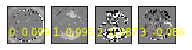

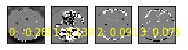

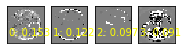

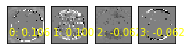

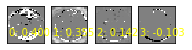

In [62]:
for i in range(fc.shape[0]):
    #visualize_latent(fc[i]*latent2[row],figsize=(10,20),cols=8,
    #                 vmin=-0.002,vmax=0.002,cmap='gray',label_color='yellow',showSum=True, fontsize=10)
    #plt.savefig(prefix+'_fcdotlatent2_ch{0:1d}.jpg'.format(i))
    inner = fc[i]*latent2[row]
    print(inner.shape)
    res = (fc[i]*latent2[row]).sum(axis=(1,2))
    index = (torch.argsort(torch.abs(res)))
    select = inner[[index[-1],index[-2],index[-3],index[-4]],:,:]
    visualize_latent(select,figsize=(3,12),cols=4,
                     vmin=-0.002,vmax=0.002,cmap='gray',label_color='yellow',showSum=True, fontsize=10)

In [22]:
def norm(v):
    return np.sqrt((v*v).sum())
def kernel_dot(w):
    N = w.shape[0]
    M = np.zeros(shape=(N,N), dtype=np.float)
    for i in range(N):
        for j in range(N):
            M[i,j] = (w[i,:,:]*w[j,:,:]).sum()/(norm(w[i,:,:])*norm(w[j,:,:]))
    return M

In [23]:
np.rank(w[:,0,:,:].reshape(w.shape[0],w.shape[2]*w.shape[3]))

/Users/cheung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  """Entry point for launching an IPython kernel.


2

In [24]:
latent2.shape

torch.Size([4, 128, 27, 27])

In [25]:
model

Autocalibration6(
  (_conv2d1): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d1_maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_conv2d2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d2_maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_fc): Linear(in_features=93312, out_features=7, bias=True)
)

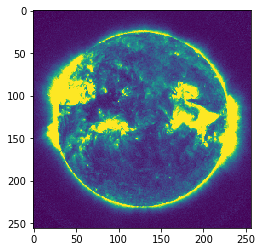

In [27]:
plt.imshow(input_data[row,0,:,:].numpy(),vmax=0.9)

In [96]:
def visualize(img,latent):
    nc = img.shape[0]
    fig, ax=plt.subplots(1,nc,figsize=(10*nc,10))
    for c in range(nc):
        ax[c].imshow(img[c],vmin=0,vmax=1, cmap='gray')
        ax[c].set_title('{}'.format(channels[c]),fontsize=30)
    plt.show()
    nc = latent.shape[0]
    fig, ax=plt.subplots(int(nc/8),8, figsize=(10,10))
    for c in range(nc):
        ax[int(c/8), c%8].imshow(latent[c],vmin=0,vmax=2,cmap='jet')
        ax[int(c/8), c%8].get_xaxis().set_visible(False)
        ax[int(c/8), c%8].get_yaxis().set_visible(False)
        ax[int(c/8), c%8].margins(0.0,0.0)
        ax[int(c/8), c%8].set_title('{}'.format(c))
    plt.show()

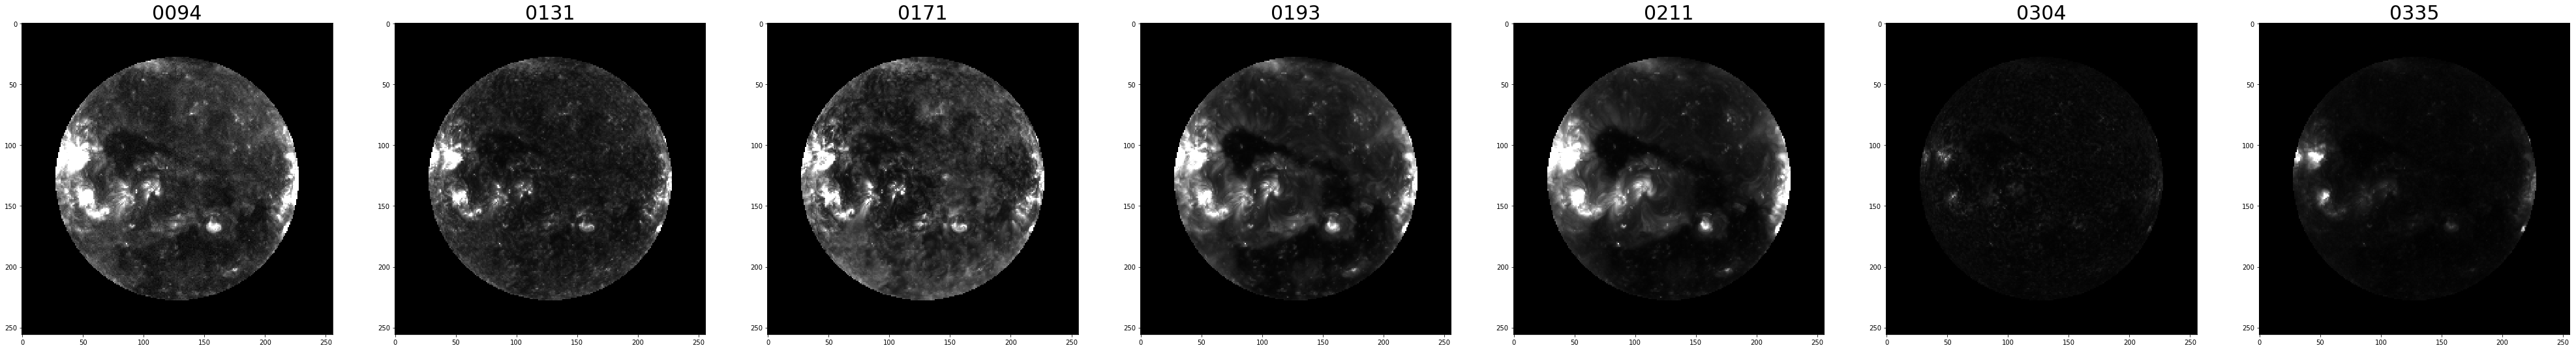

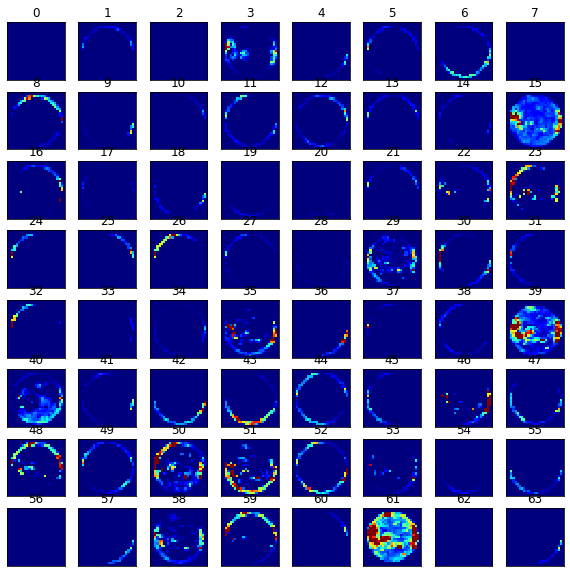

In [53]:
def panel(x):
    shape = x.shape
    img = np.zeros(shape=(shape[0]*shape[2],shape[1]*shape[3]), dtype=np.float)
    for i in range(shape[0]):
        for j in range(shape[1]):
            img[i*shape[2]:(i+1)*shape[2], j*shape[3]:(j+1)*shape[3]] = x[i,j,:,:]
    return img

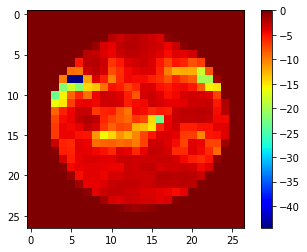

In [138]:
plt.imshow(latent[12,7,:,:].numpy(), interpolation='nearest', cmap='jet')
plt.colorbar()

In [23]:
model.state_dict()['_conv2d1.weight'].shape

torch.Size([64, 7, 3, 3])

In [24]:
model.state_dict()['_conv2d2.weight'].shape

torch.Size([128, 64, 3, 3])

In [66]:
input_data.shape

torch.Size([128, 7, 256, 256])

In [ ]:
np.b